# 1. 필요한 라이브러리 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
from scipy.stats import pearsonr
from scipy.signal import find_peaks

# 2. 데이터 로드

In [2]:
# UCI-HAR 데이터 로드
def load_data():
    # UCI-HAR 데이터 로드
    uci_har_path = './원본 데이터/UCI HAR Dataset/'
    gyro_x_train = pd.read_csv(uci_har_path + 'train/Inertial Signals/body_gyro_x_train.txt', sep='\s+', header=None).values
    gyro_y_train = pd.read_csv(uci_har_path + 'train/Inertial Signals/body_gyro_y_train.txt', sep='\s+', header=None).values
    gyro_z_train = pd.read_csv(uci_har_path + 'train/Inertial Signals/body_gyro_z_train.txt', sep='\s+', header=None).values
    labels_train = pd.read_csv(uci_har_path + 'train/y_train.txt', sep='\s+', header=None).values.flatten()

    uci_har = pd.DataFrame(np.stack([gyro_x_train.flatten(), gyro_y_train.flatten(), gyro_z_train.flatten()], axis=1), columns=['X', 'Y', 'Z'])
    uci_har['Label'] = np.repeat(labels_train, gyro_x_train.shape[1])  # 각 샘플에 대한 라벨 추가

    # 자이로 데이터 로드
    gyro_data = pd.read_csv('./원본 데이터/자이로 데이터.csv')
    
    return uci_har, gyro_data

uci_har_df, gyro_data = load_data()

# 3. 기본 통계 비교

In [15]:
# 기본 통계 비교 
def compare_basic_stats(uci_data, gyro_data):
    stats = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
    uci_stats = uci_data[['X', 'Y', 'Z']].describe().loc[stats]
    gyro_stats = gyro_data[['X', 'Y', 'Z']].describe().loc[stats]

    comparison = pd.concat([uci_stats, gyro_stats], axis=0, keys=['UCI-HAR', 'Gyro']).stack(0).unstack(1)
    
    print("기본 통계 비교:")
    print(comparison)
    print("\n")

compare_basic_stats(uci_har_df, gyro_data)

기본 통계 비교:
                  mean          std           min          25%          50%  \
UCI-HAR X     0.000506     0.406815     -4.733656    -0.044328     0.000138   
        Y    -0.000824     0.381855     -5.974330    -0.055065    -0.000578   
        Z     0.000113     0.255743     -2.763014    -0.025253     0.000490   
Gyro    X -3702.910910  2996.991394 -32768.000000 -6080.000000 -3712.000000   
        Y  2829.783692  4704.889694 -30016.000000  -256.000000  3392.000000   
        Z   966.719159  3819.702620 -32768.000000 -1280.000000   576.000000   

                   75%           max  
UCI-HAR X     0.054847      4.155473  
        Y     0.036958      5.746062  
        Z     0.049530      2.365982  
Gyro    X -1792.000000  32512.000000  
        Y  7104.000000  32384.000000  
        Z  3584.000000  32640.000000  




### **UCI-HAR 데이터셋 (X, Y, Z 축)**
**평균(mean):**   
- X, Y, Z 축의 평균은 각각 `0.0005`, `-0.0008`, `0.0001`로 거의 0에 가까운 값
- 이는 UCI-HAR 데이터셋에서 자이로스코프 값이 전반적으로 큰 편차 없이 움직임이 중심에 몰려 있음을 나타냄

**표준편차(std):**   
- X, Y, Z 축의 표준편차는 각각 `0.4068`, `0.3819`, `0.2557`로 나타나며, 이는 데이터의 변화 폭이 크지 않음을 보여줌
- 즉, 데이터가 상대적으로 안정적인 범위 내에서 분포하고 있음을 의미

**최소(min)와 최대(max):**   
- X, Y, Z 축의 최소값은 각각 `-4.73`, `-5.97`, `-2.76`이고, 최대값은 각각 `4.16`, `5.75`, `2.37`로, UCI-HAR 데이터는 비교적 작은 값의 범위를 가지며,
- 이는 센서가 허리 위치에서 측정된 데이터임을 반영

**사분위수 (25%, 50%, 75%):**   
- 중간 값(50%)은 0에 매우 가까우며, 이는 센서에서 수집된 데이터가 중심을 기준으로 대칭적으로 분포하고 있음을 보여줌


# 4. 분포 시각화

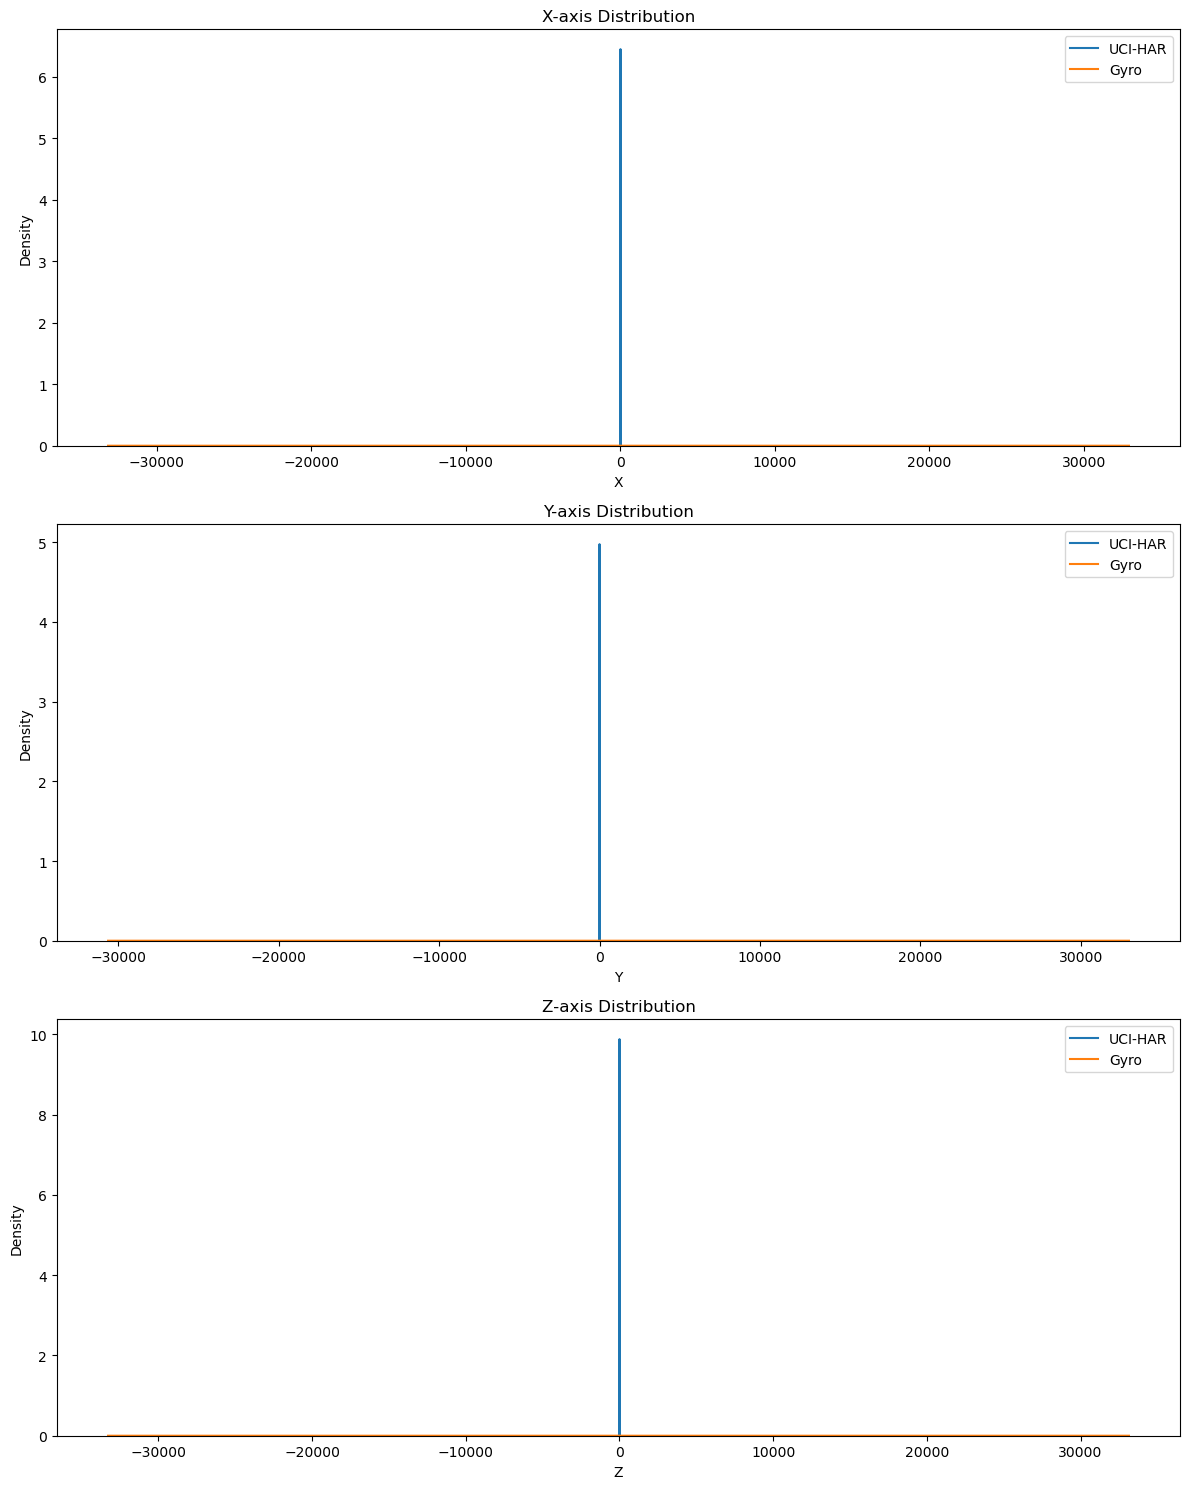

In [4]:
def plot_distributions(uci_data, gyro_data):
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    for i, axis in enumerate(['X', 'Y', 'Z']):
        sns.kdeplot(uci_data[axis], ax=axes[i], label='UCI-HAR')
        sns.kdeplot(gyro_data[axis], ax=axes[i], label='Gyro')
        axes[i].set_title(f'{axis}-axis Distribution')
        axes[i].legend()
    plt.tight_layout()
    plt.show()

plot_distributions(uci_har_df, gyro_data)

# 5. 주파수 도메인 분석:

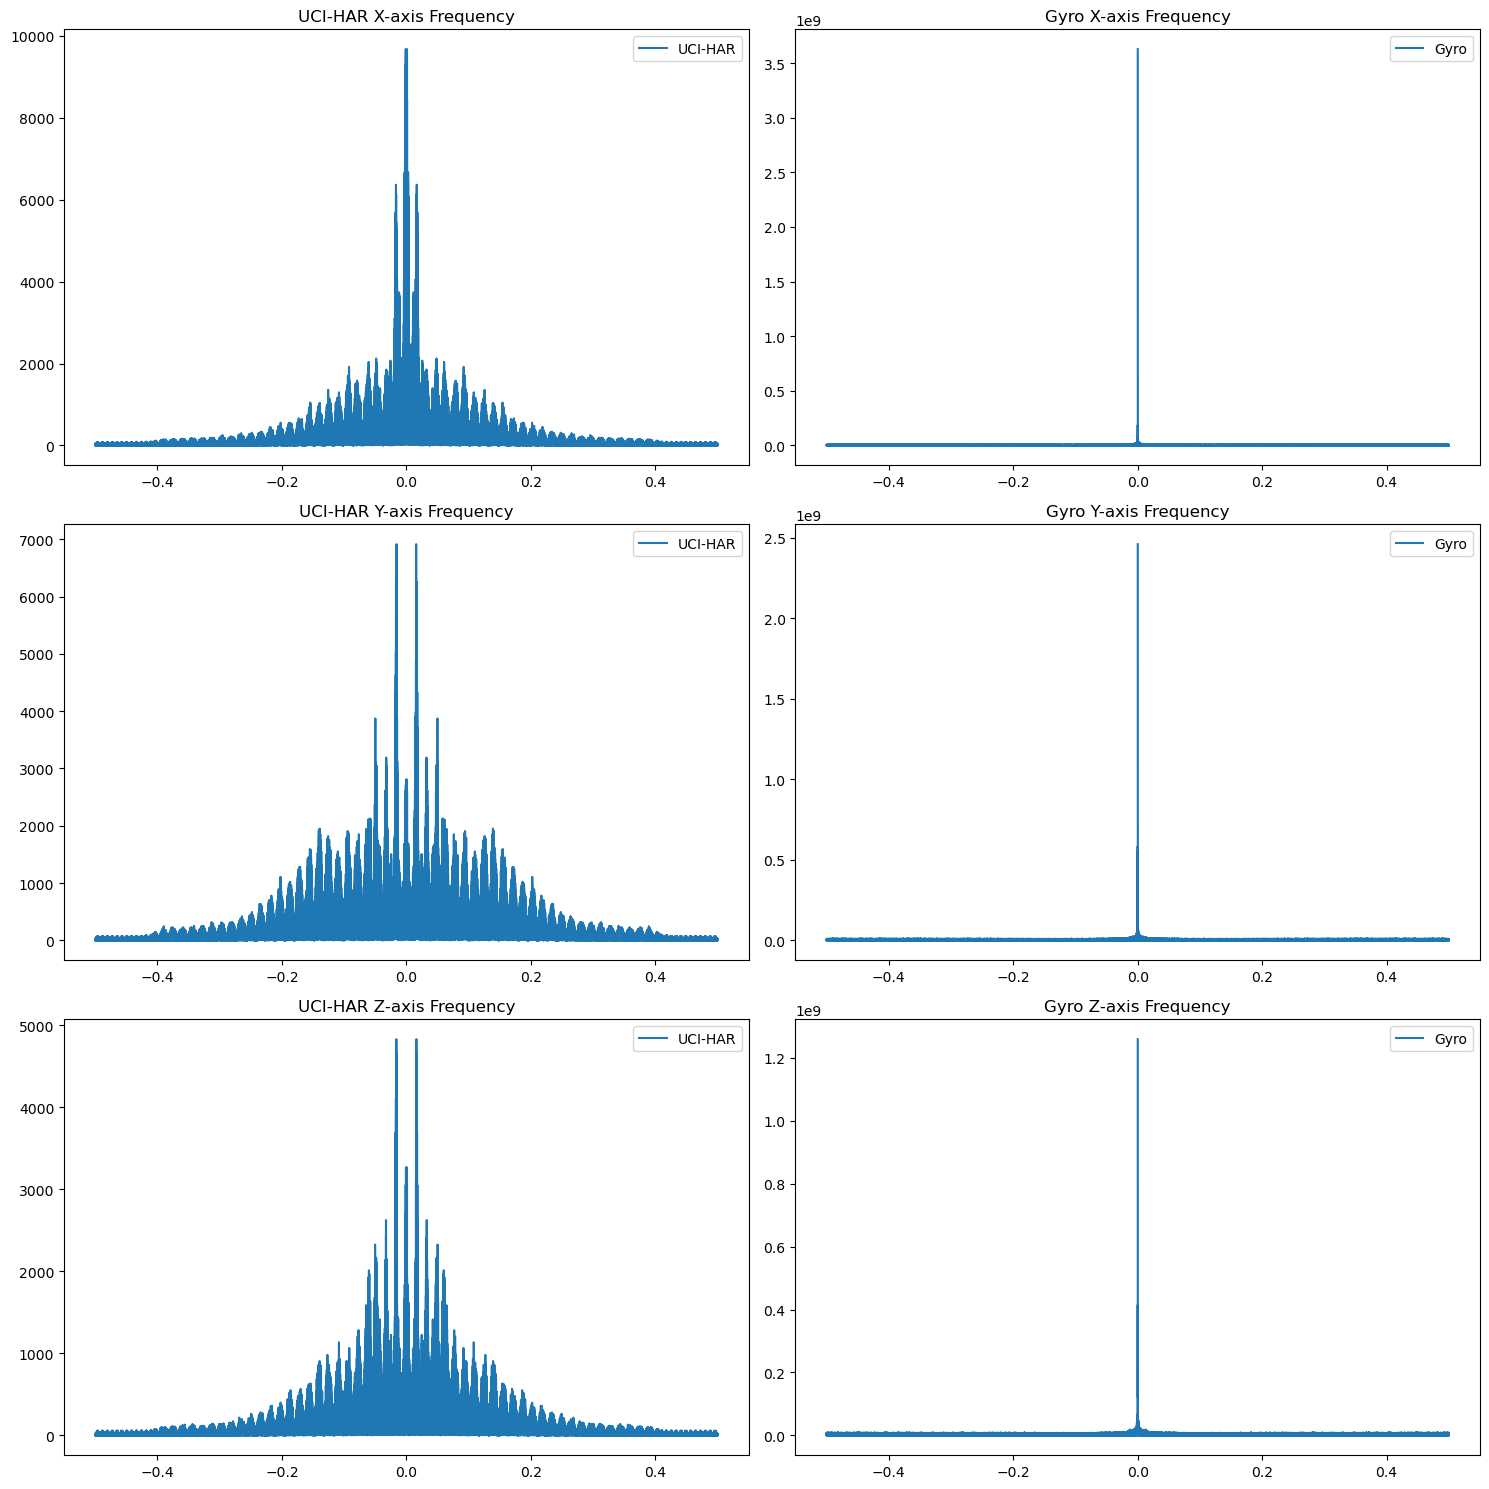

In [5]:
def compare_frequency_domain(uci_data, gyro_data):
    def fft_analysis(data):
        # 데이터를 numpy 배열로 변환
        data_array = np.array(data)
        # 데이터 길이를 동일하게 맞춤 (더 짧은 데이터에 맞춤)
        min_length = min(len(uci_data), len(gyro_data))
        data_array = data_array[:min_length]
        
        fft_result = np.fft.fft(data_array)
        freq = np.fft.fftfreq(len(data_array))
        return freq, np.abs(fft_result)
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    for i, axis in enumerate(['X', 'Y', 'Z']):
        uci_freq, uci_amp = fft_analysis(uci_data[axis])
        gyro_freq, gyro_amp = fft_analysis(gyro_data[axis])
        
        axes[i, 0].plot(uci_freq, uci_amp, label='UCI-HAR')
        axes[i, 0].set_title(f'UCI-HAR {axis}-axis Frequency')
        axes[i, 1].plot(gyro_freq, gyro_amp, label='Gyro')
        axes[i, 1].set_title(f'Gyro {axis}-axis Frequency')
        
        axes[i, 0].legend()
        axes[i, 1].legend()
    
    plt.tight_layout()
    plt.show()

compare_frequency_domain(uci_har_df, gyro_data)

# 6. 상관관계 분석:

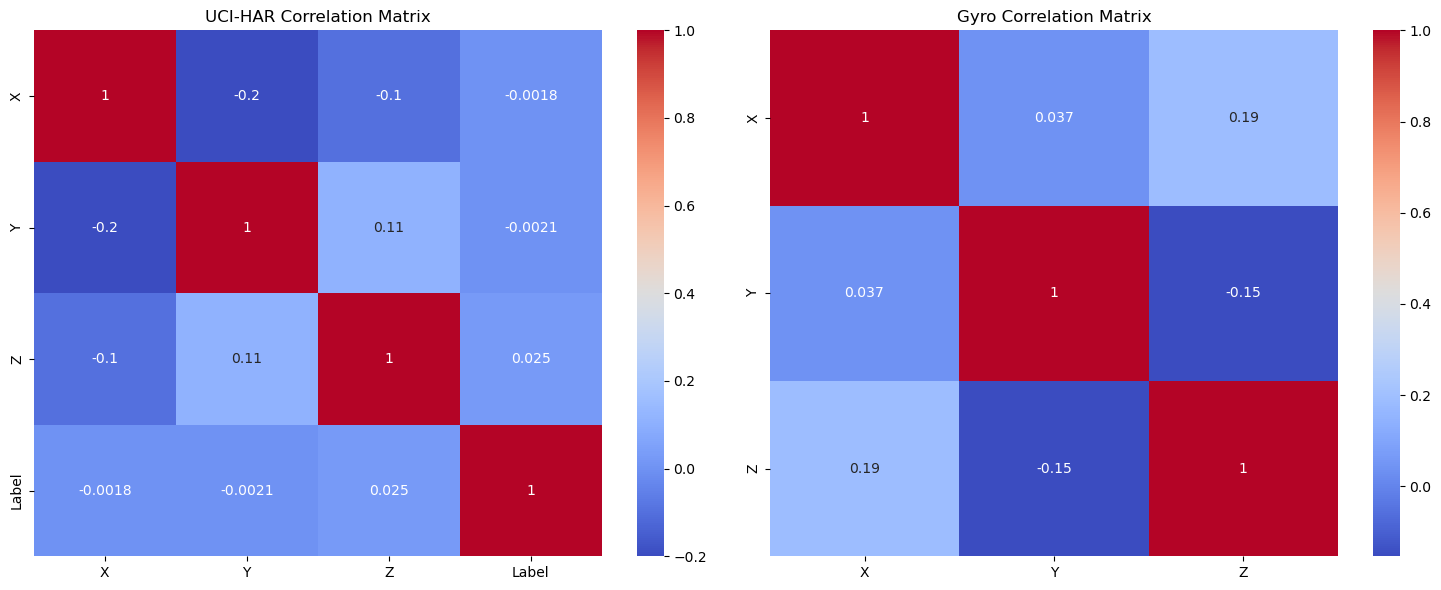

In [6]:
def compare_correlation(uci_data, gyro_data):
    uci_corr = uci_data.corr()
    gyro_corr = gyro_data[['X', 'Y', 'Z']].corr()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    sns.heatmap(uci_corr, annot=True, cmap='coolwarm', ax=ax1)
    ax1.set_title('UCI-HAR Correlation Matrix')
    sns.heatmap(gyro_corr, annot=True, cmap='coolwarm', ax=ax2)
    ax2.set_title('Gyro Correlation Matrix')
    plt.tight_layout()
    plt.show()

compare_correlation(uci_har_df, gyro_data)

# 7. 시계열 패턴 비교

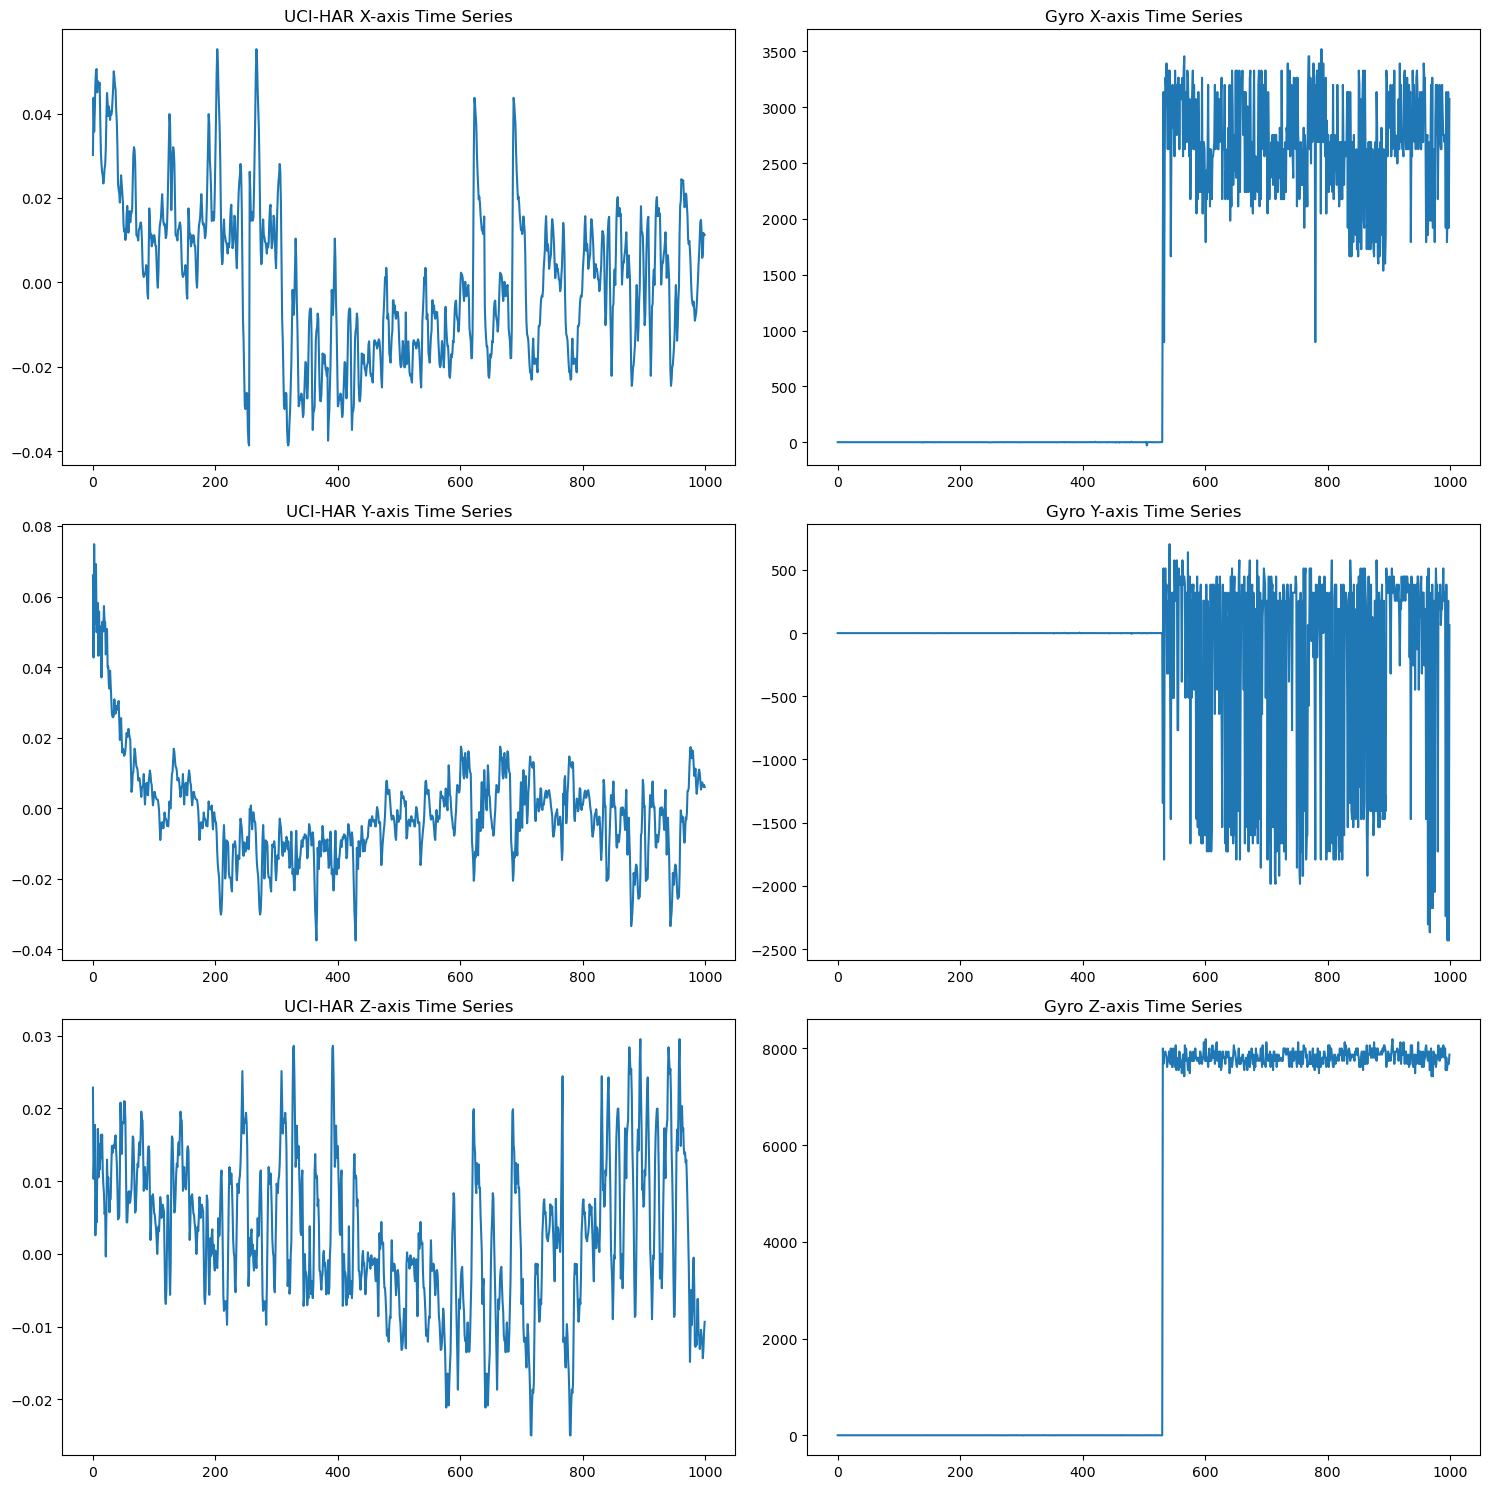

In [7]:
def compare_time_series(uci_data, gyro_data, samples=1000):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    for i, axis in enumerate(['X', 'Y', 'Z']):
        axes[i, 0].plot(uci_data[axis][:samples])
        axes[i, 0].set_title(f'UCI-HAR {axis}-axis Time Series')
        axes[i, 1].plot(gyro_data[axis][:samples])
        axes[i, 1].set_title(f'Gyro {axis}-axis Time Series')

    plt.tight_layout()
    plt.show()

compare_time_series(uci_har_df, gyro_data)

# 8. 신호 변동성 분석

In [8]:
def analyze_signal_variability(uci_data, gyro_data):
    for axis in ['X', 'Y', 'Z']:
        uci_var = uci_data[axis].var()
        gyro_var = gyro_data[axis].var()
        print(f"{axis}-axis 신호 변동성:")
        print(f"UCI-HAR: {uci_var:.4f}, Gyro: {gyro_var:.4f}\n")

analyze_signal_variability(uci_har_df, gyro_data)

X-axis 신호 변동성:
UCI-HAR: 0.1655, Gyro: 8981957.4158

Y-axis 신호 변동성:
UCI-HAR: 0.1458, Gyro: 22135987.0350

Z-axis 신호 변동성:
UCI-HAR: 0.0654, Gyro: 14590128.1084



# 9. 피크 탐지 (Peak Detection)

C:\Users\user\AppData\Local\Temp\ipykernel_3128\1135958158.py:16: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_3128\1135958158.py:16: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_3128\1135958158.py:16: UserWarning: Glyph 53456 (\N{HANGUL SYLLABLE TAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_3128\1135958158.py:16: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53356

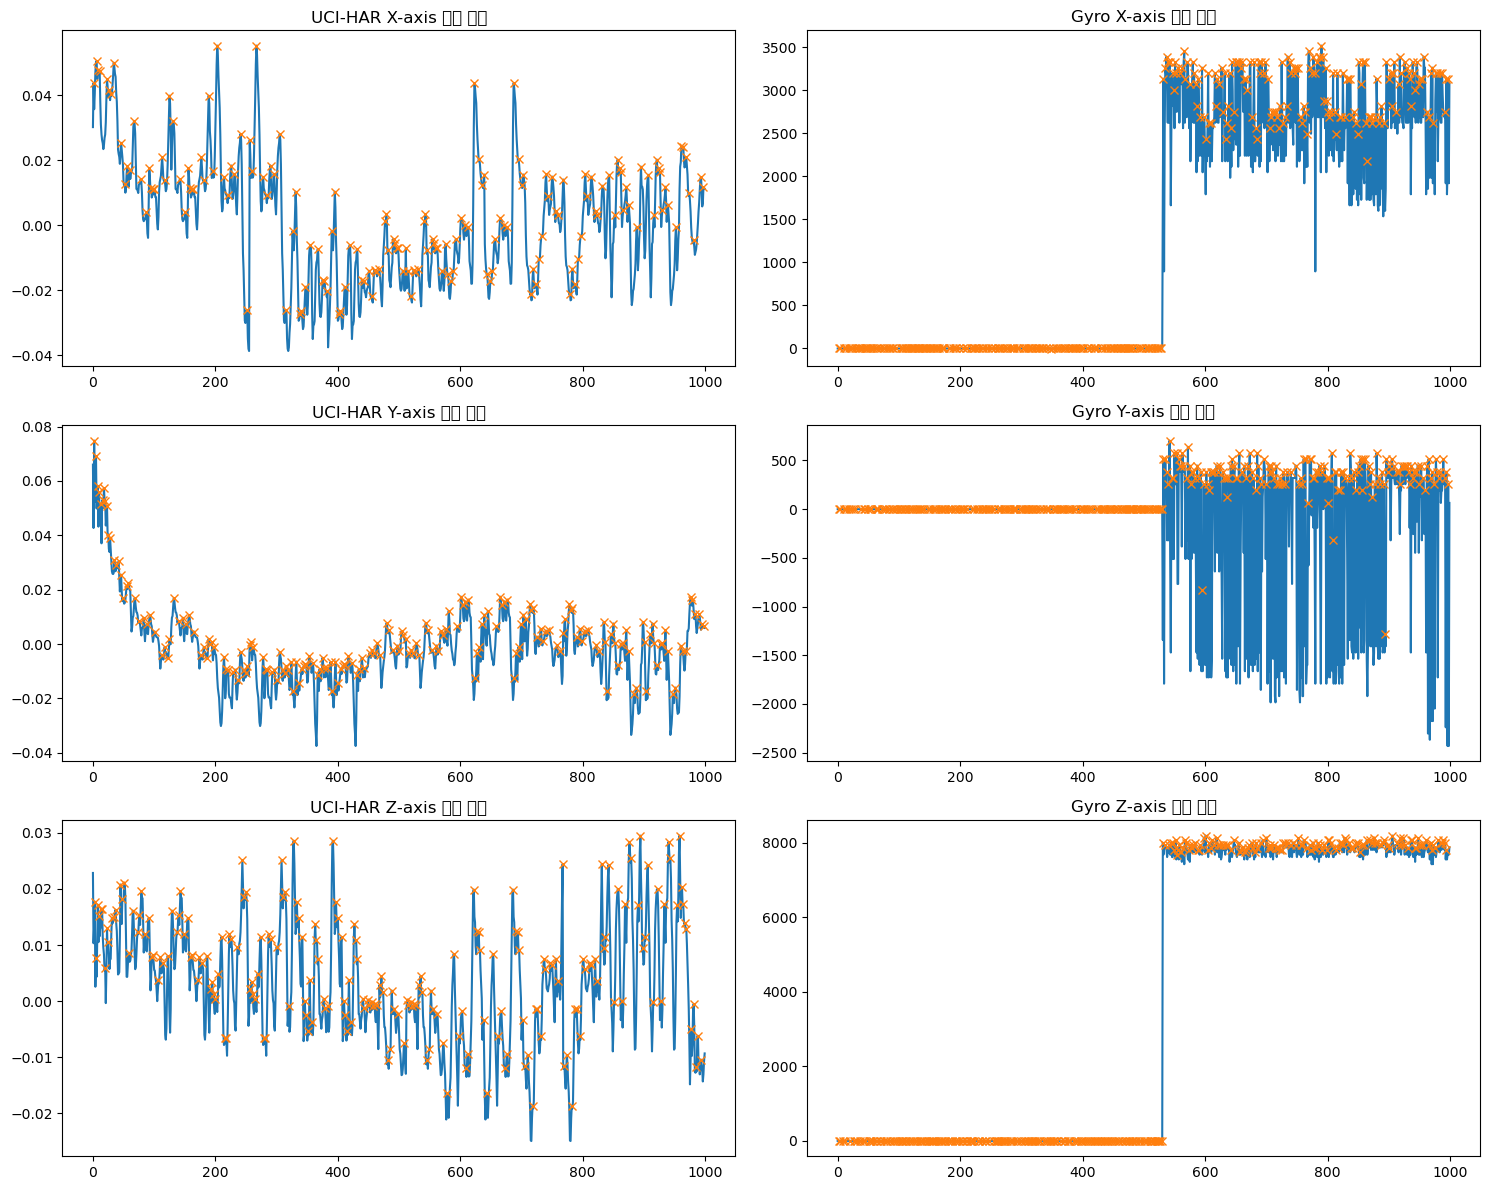

In [9]:
def detect_peaks(uci_data, gyro_data, samples=1000):
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    for i, axis in enumerate(['X', 'Y', 'Z']):
        uci_peaks, _ = find_peaks(uci_data[axis][:samples], height=None)
        gyro_peaks, _ = find_peaks(gyro_data[axis][:samples], height=None)
        
        axes[i, 0].plot(uci_data[axis][:samples])
        axes[i, 0].plot(uci_peaks, uci_data[axis].iloc[uci_peaks], "x")
        axes[i, 0].set_title(f'UCI-HAR {axis}-axis 피크 탐지')
        
        axes[i, 1].plot(gyro_data[axis][:samples])
        axes[i, 1].plot(gyro_peaks, gyro_data[axis].iloc[gyro_peaks], "x")
        axes[i, 1].set_title(f'Gyro {axis}-axis 피크 탐지')

    plt.tight_layout()
    plt.show()

detect_peaks(uci_har_df, gyro_data)

# 10. 신호의 에너지 계산 (Signal Energy Calculation)

In [10]:
def calculate_signal_energy(uci_data, gyro_data):
    def signal_energy(signal):
        return np.sum(signal**2)

    for axis in ['X', 'Y', 'Z']:
        uci_energy = signal_energy(uci_data[axis])
        gyro_energy = signal_energy(gyro_data[axis])
        print(f"{axis}-axis 신호 에너지:")
        print(f"UCI-HAR: {uci_energy:.4f}, Gyro: {gyro_energy:.4f}\n")

calculate_signal_energy(uci_har_df, gyro_data)

X-axis 신호 에너지:
UCI-HAR: 155743.5949, Gyro: 134367948703505.2500

Y-axis 신호 에너지:
UCI-HAR: 137218.5742, Gyro: 178480213316269.7188

Z-axis 신호 에너지:
UCI-HAR: 61549.3592, Gyro: 91921378581873.6562



# 11. 추세 분석 (Trend Analysis)

C:\Users\user\AppData\Local\Temp\ipykernel_3128\1214692688.py:16: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_3128\1214692688.py:16: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_3128\1214692688.py:16: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_3128\1214692688.py:16: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4946

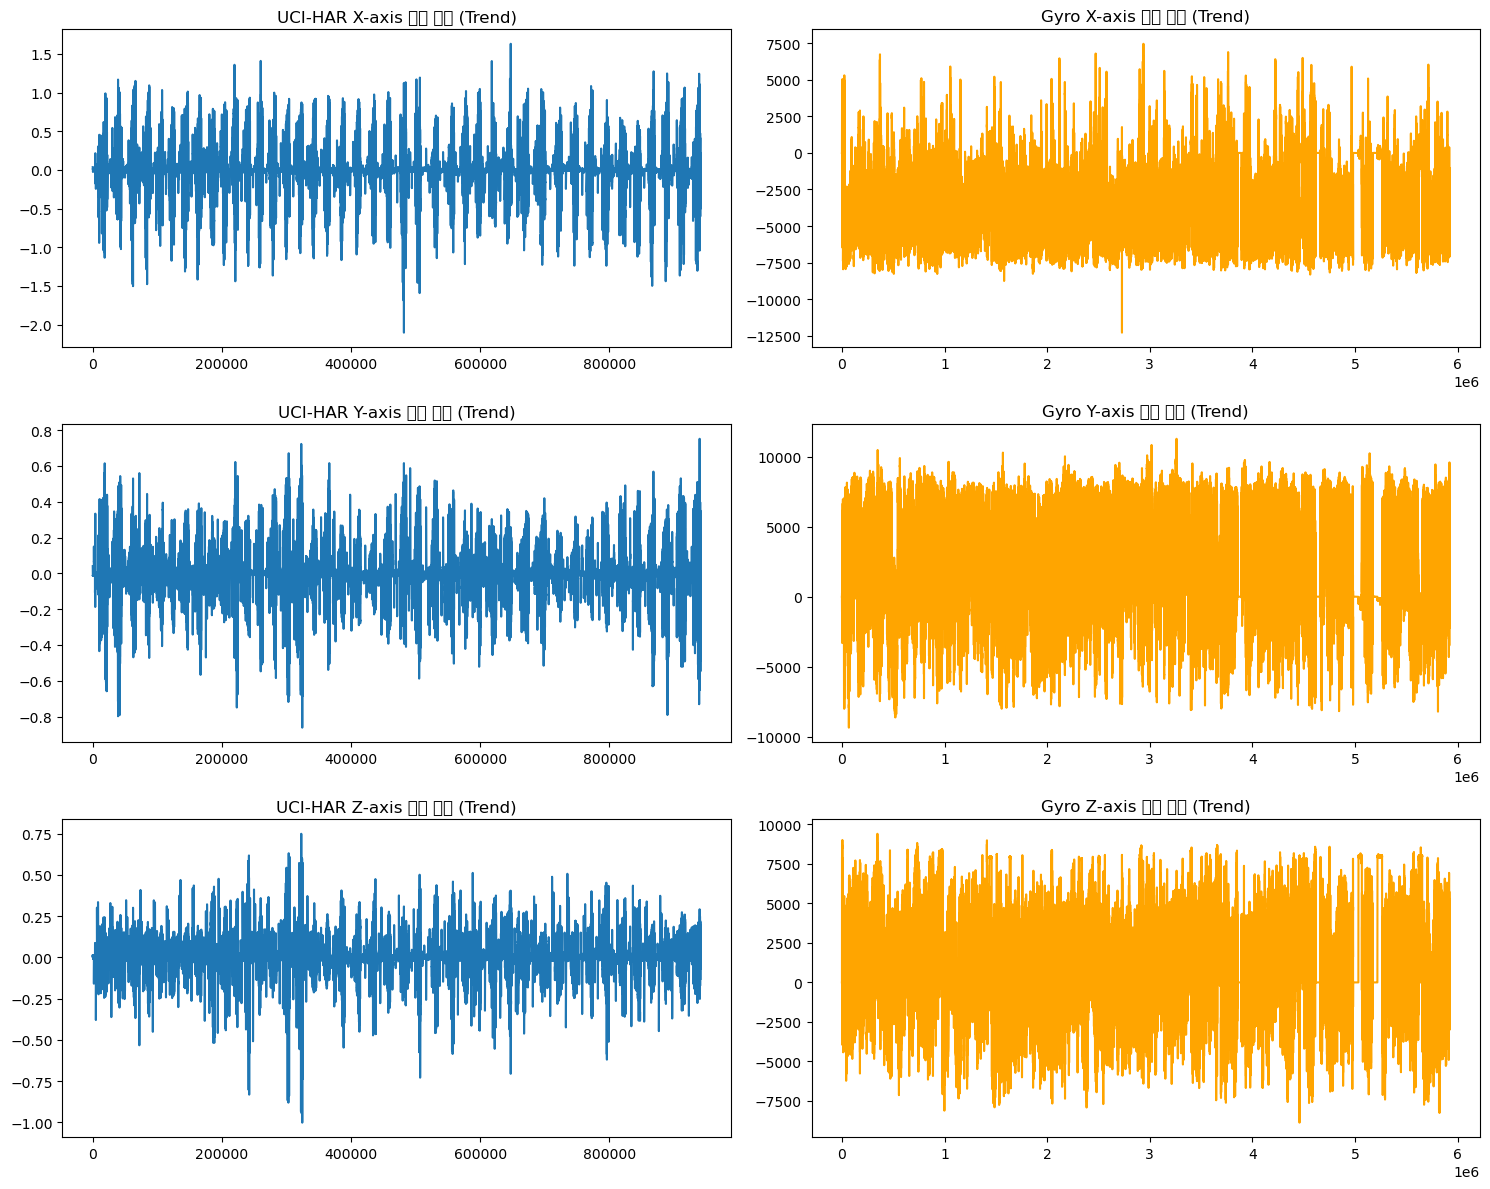

In [11]:
def analyze_trends(uci_data, gyro_data, window=50):
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))

    for i, axis in enumerate(['X', 'Y', 'Z']):
        # 이동 평균(Trend) 계산
        uci_trend = uci_data[axis].rolling(window=window).mean()
        gyro_trend = gyro_data[axis].rolling(window=window).mean()

        # 시각화
        axes[i, 0].plot(uci_trend, label='UCI-HAR')
        axes[i, 0].set_title(f'UCI-HAR {axis}-axis 추세 분석 (Trend)')
        
        axes[i, 1].plot(gyro_trend, label='Gyro', color='orange')
        axes[i, 1].set_title(f'Gyro {axis}-axis 추세 분석 (Trend)')

    plt.tight_layout()
    plt.show()

analyze_trends(uci_har_df, gyro_data)

# 11. 결과 요약

In [12]:
def summarize_findings(uci_data, gyro_data):
    print("데이터셋 간 주요 차이점:")
    
    # 평균 비교
    for axis in ['X', 'Y', 'Z']:
        uci_mean = uci_data[axis].mean()
        gyro_mean = gyro_data[axis].mean()
        print(f"{axis}-axis 평균 차이: {uci_mean - gyro_mean:.4f}")
    
    # 표준편차 비교
    for axis in ['X', 'Y', 'Z']:
        uci_std = uci_data[axis].std()
        gyro_std = gyro_data[axis].std()
        print(f"{axis}-axis 표준편차 차이: {uci_std - gyro_std:.4f}")
    
    # 상관관계 차이
    uci_corr = uci_data[['X', 'Y', 'Z']].corr()
    gyro_corr = gyro_data[['X', 'Y', 'Z']].corr()
    print("\n상관관계 차이:")
    corr_diff = uci_corr - gyro_corr
    print(corr_diff)

summarize_findings(uci_har_df, gyro_data)

데이터셋 간 주요 차이점:
X-axis 평균 차이: 3702.9114
Y-axis 평균 차이: -2829.7845
Z-axis 평균 차이: -966.7190
X-axis 표준편차 차이: -2996.5846
Y-axis 표준편차 차이: -4704.5078
Z-axis 표준편차 차이: -3819.4469

상관관계 차이:
          X         Y         Z
X  0.000000 -0.236934 -0.285683
Y -0.236934  0.000000  0.266782
Z -0.285683  0.266782  0.000000


## 차이점
1. 데이터 구조:
> UCI-HAR 데이터는 X, Y, Z 축의 자이로스코프 데이터만 포함   
> 자이로 데이터는 추가적인 정보(WorkDate, UserCode, RegisterDate)를 포함   
2. 스케일 차이:
> UCI-HAR 데이터는 -6에서 6 사이의 값을 가짐   
> 자이로 데이터는 -32768에서 32640 사이의 값을 가짐   
> 이는 자이로 데이터가 raw 센서 데이터일 가능성이 높으며, 정규화되지 않았음을 시사   
3. 평균 차이:
> X, Y, Z 축 모두에서 큰 평균 차이가 있음
> 이는 두 데이터셋의 중심점이 매우 다르다는 것을 의미
4. 표준편차 차이:
> 자이로 데이터의 표준편차가 UCI-HAR 데이터보다 훨씬 큼
> 이는 자이로 데이터의 변동성이 더 크다는 것을 의미
5. 상관관계 차이:
> 축 간 상관관계에 차이가 있음
> 특히 X-Z축과 Y-Z축 간의 상관관계 차이가 크게 나타남

### 이러한 차이점을 고려하여 다음과 같은 조치를 취함

1. 데이터 정규화:
> 자이로 데이터를 UCI-HAR 데이터와 유사한 스케일로 정규화   
> 예를 들어, Min-Max 스케일링이나 표준화(Z-score)를 적용할 수 있습니다.
2. 중심 조정:
> 자이로 데이터의 평균을 0에 가깝게 조정   
> 이는 데이터의 중심을 맞추는 데 도움
3. 특성 공학:
> 자이로 데이터의 추가 정보(WorkDate, UserCode 등)를 활용하여 새로운 특성을 만들어낼 수 있음
4. 데이터 필터링:
> 자이로 데이터의 이상치를 제거하거나 필터링하여 UCI-HAR 데이터와 유사한 분포를 가지도록 조정 가능
5. 모델 조정:
> 두 데이터셋 간의 차이를 고려하여 모델의 아키텍처나 하이퍼파라미터를 조정할 필요가 있음   
> 이러한 조치를 통해 UCI-HAR 데이터로 학습한 모델을 자이로 데이터에 적용할 때 발생할 수 있는 문제를 최소화하고, 더 나은 성능을 얻을 수 있음